In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Mankevic, Karina (1036163)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I added 6 hidden layers with  ReLU act.funct. as it is fast to compute. Due to problem's classification nature, the last layer with 10 neurons has softmax act.funct., which transforms input into probability for each of the 10 classes, and categorical crossentropy is used as loss. SGD optimizer performs well here. Val. accuracy reaches 84%, which is good performance, considering that tuning is not performed. Val. loss overall decreases. Strong overfitting and no underfitting takes place. (length: 492)



Max val score: 84.43%


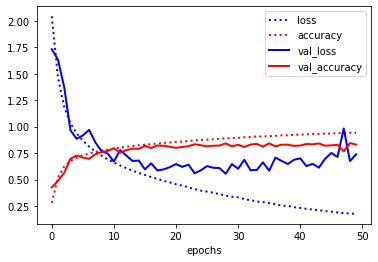

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 1528)              4695544   
_________________________________________________________________
dense_53 (Dense)             (None, 756)               1155924   
_________________________________________________________________
dense_54 (Dense)             (None, 370)               280090    
_________________________________________________________________
dense_55 (Dense)             (None, 177)               65667     
_________________________________________________________________
dense_56 (Dense)             (None, 80)                14240     
_________________________________________________________________
dense_57 (Dense)             (None, 32)               

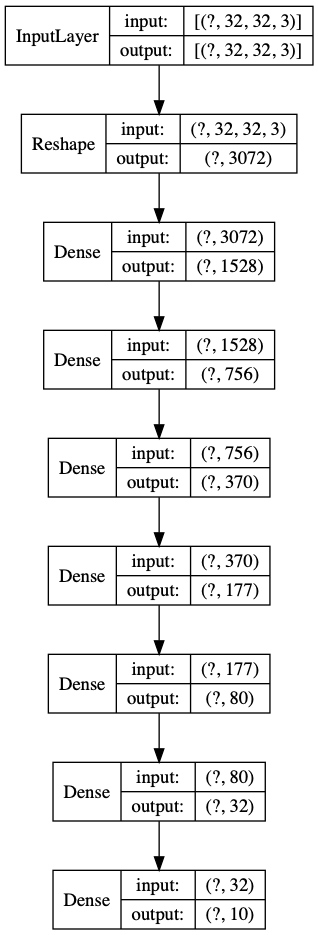

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

With gray scale, the number of input neurons decreases by factor of 3 (1024 instead of 3072). The number of trainable params is now 674,415 (vs. 6,214,387 in prev. model); this is big difference. Despite it, the performance is roughly the same. Val. accuracy reaches ~83%, meaning that using gray scale is better: the model trains faster, while giving almost same performance. It is logical as the net learns digits' shapes, where color does not matter. Overfitting is decreased and no underfitiing. (length: 500)



Max val score: 84.14%


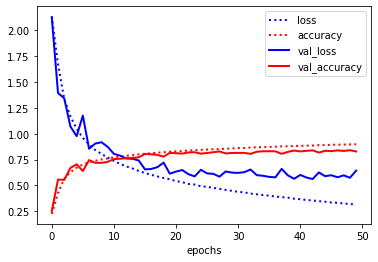

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 504)               516600    
_________________________________________________________________
dense_12 (Dense)             (None, 244)               123220    
_________________________________________________________________
dense_13 (Dense)             (None, 114)               27930     
_________________________________________________________________
dense_14 (Dense)             (None, 49)                5635      
_________________________________________________________________
dense_15 (Dense)             (None, 17)                850       
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Batch normalizaiton works well in this model, especially when applied right after input layer. This way, model's input is normalized, and the model starts performing well already in the first several epochs. Adding several dropout layers also works well when 20% of neurons get zeroed-out. Changing learning rate from default(0.01) to 0.1 stimulates faster learning. Batch size 64 improves performance. Neither overfit nor underfit is observed. The model is reaching 87% val.accuracy (length: 484)



Max val score: 87.30%


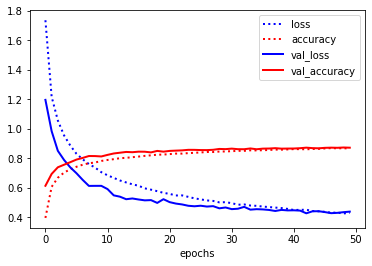

def build_model_1_3():
  model = models.Sequential()
  # input layer:
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  # intermediate layers:
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(504, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(244, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(114, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(49, activation='relu'))
  model.add(layers.Dense(17, activation='relu'))
  # output layer:
  model.add(layers.Dense(10, activation='softmax'))

  sgd_opt = tf.keras.optimizers.SGD(learning_rate=0.1)
  model.compile(optimizer=sgd_opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

First, I added 3 blocks (2 convolution layers in each, where after each block MaxPooling is applied), followed by flattening, 1 dense and 1 output layer. In deeper layers, I used increasingly more filters (from 32 to 128), as it helps preserving info about the input while MaxPooling is descreasing the resolution. With this architecture the model showed good accuracy, but overfitted. Adding dropout layers, tuning their dropout rates and adding batch normalization between convolution layers helped against overfitting. Stochastic Gradient descent optimizer works well with learning rate 0.1 as the net learns faster. The final model reaches 95% val.accuracy, which is very good. Val.loss overall converges to some value (excl.little spikes), neither overfitting not underfitting is observed. (length: 795)



Max val score: 95.43%


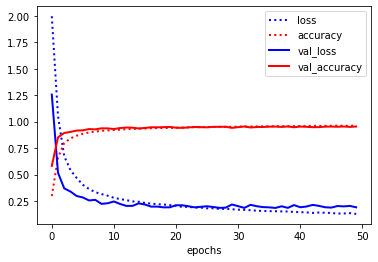

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_50 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 16, 16, 64)      

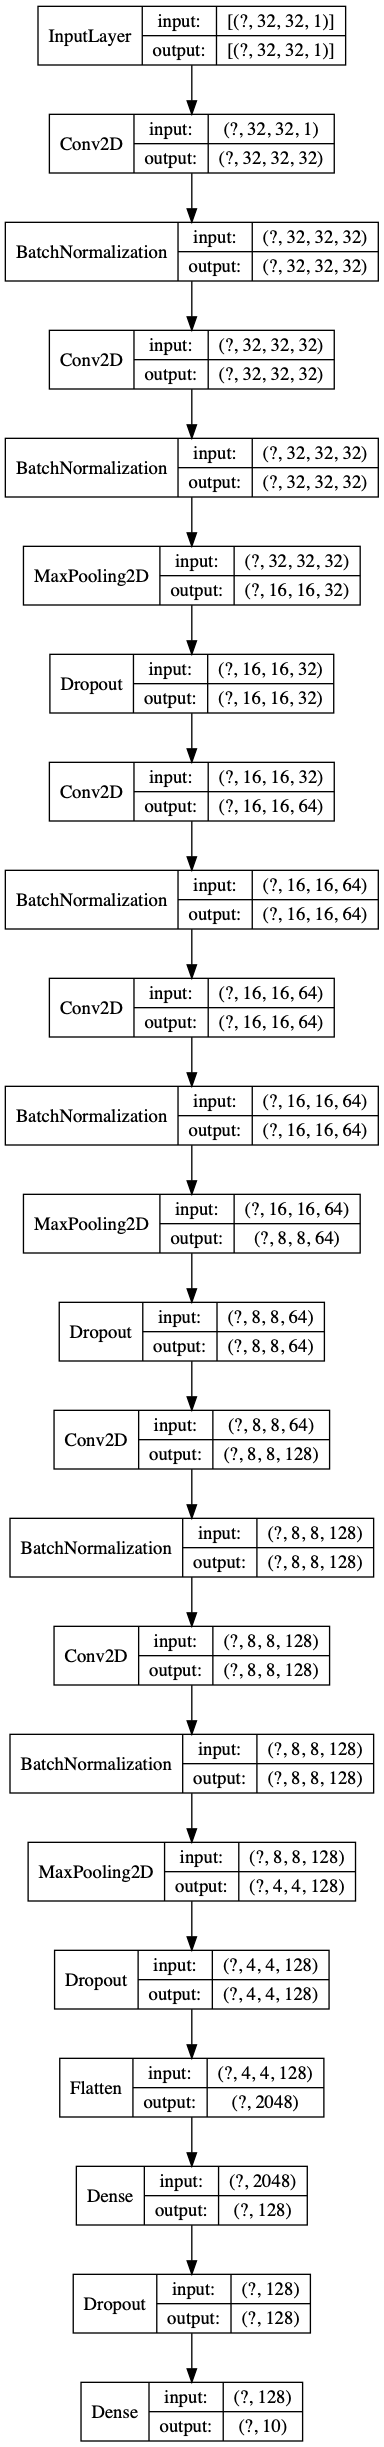

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Some augmentations work better than others; e.g, 10% zoom cuts some possibly redundant border info, still performing well. Setting ZCA whitening also works well. On the other side, flipping, shearing or rotating makes it harder to capture number shape. With heigth and width shifting the model does not train. Overall augmentations worsen image quality in this dataset, bringing the accuracy down from 95.5% to at most 93%. I left the best combo in ImageGenerator. Over-/under-fit is not observed. (length: 498)



Max val score: 93.07%


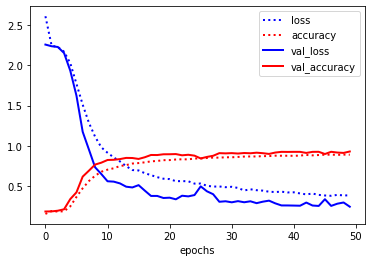


train_datagen = ImageDataGenerator(
    zoom_range=0.15,        # Zoom in up to 10%
    zca_whitening=True,    # Set ZCA whitening
)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Digits 8 and 6 are often confused (both ways). Digit 5 is often misclassified as 3 or 6. Digit 1 can be misclassified as 2, 4, 7. Digit 7 is many times misclassified as 1 and 2. Digit 3 is often misclassified as 2, 5 and 8.  Many confusions are straighformard: the shapes of misclassified digits have some elements in common. For example, digit 1 is a vertical bar, which is significant part of digits 2, 4 and 7, causing the confusion between them. Closer inspection of misclassifications for digit 1 shows that pictures often have background noise (multiple digits together, e.g. '11', '15'). Additionally, the quality of pictures is poor. Multiple pictures are blurry and unreadable. To sum up, all confusions are based either on common digit shapes, background noise or poor quality. (length: 788)

Test score: 0.93%


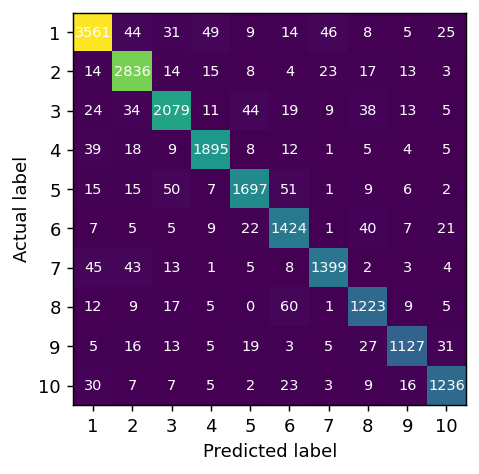

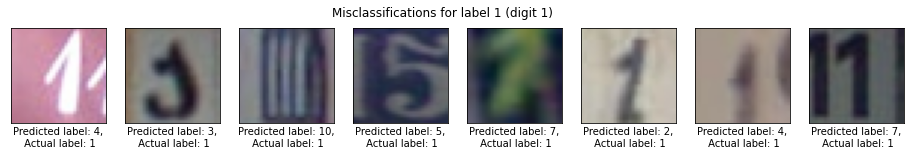

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In conv2d_1 layer all filters respond to both digits on the original picture ('85'), creating additional noise and interpreted as '85' or '86'. Despite it, in conv2d_2 layer, some filters produce output with focus only on the shape of '8', meaning that the model is actually somehow learning the correct shape. Many filters here respond to 2 circles the digit 8 is made of. Outputs of all next conv.layers become hard to interpret as the resolution decreases and abstraction increases. (length: 486)



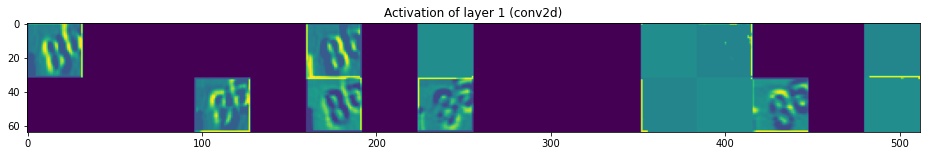

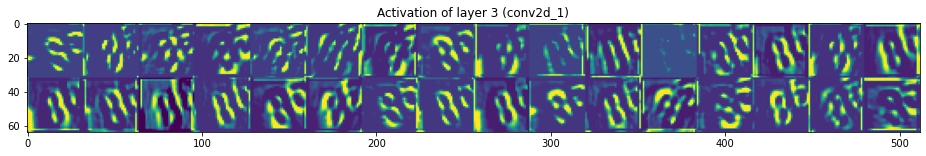

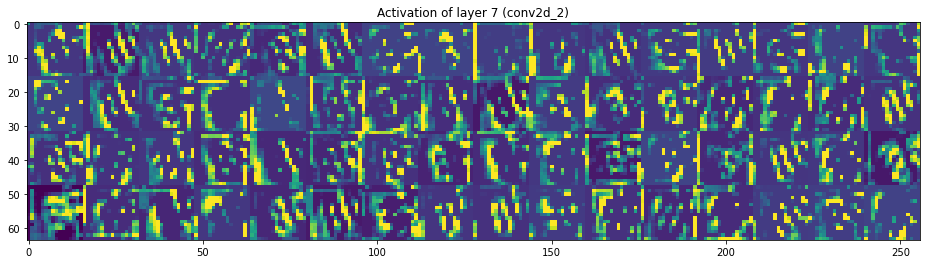

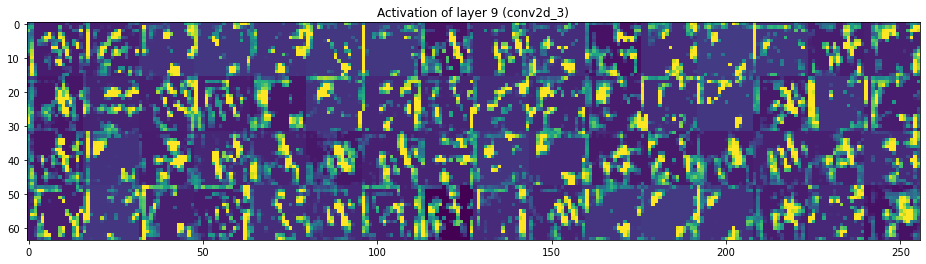

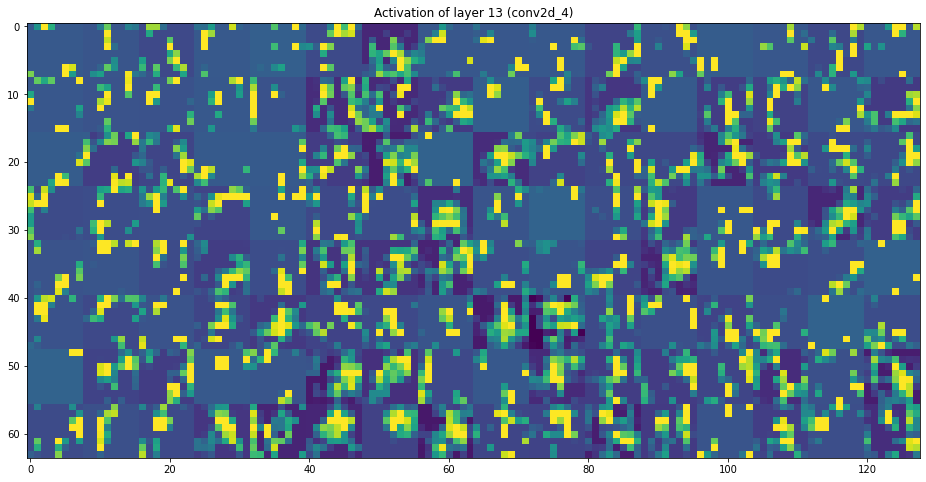

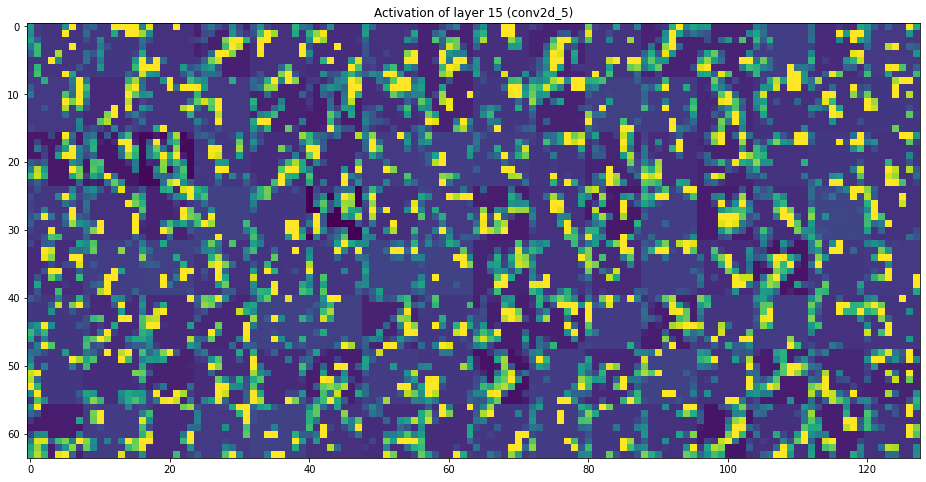

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

Predicted class: 8, Actual class: 8


def plot_activation_map():
  image_id = 0
  K.clear_session()
  model = load_model_from_file(base_dir, 'model_2_2')
  # Retrieve the picture: 
  img_tensor_gray = X_test_gray[image_id]
  x = np.expand_dims(img_tensor_gray, axis=0) 
  
  predict_class_index = np.argmax(y_pred[image_id])
  actual_class_index = np.argmax(y_test[image_id])
  print("Predicted class: {}, Actual class: {}".format(predict_class_index + 1, actual_class_index + 1))

  image_output = model.output[:,predict_class_index]

  # There is the output feature map of the conv layer,
  # the last convolutional layer in VGG16
  last_conv_layer = model.get_layer('conv2d_5')  

  # This is the gradient of the class with regard to
  # the output feature map of `block5_conv3`
  grads = K.gradients(image_output, last_conv_layer.output)[0]

  # This is a vector, where each entry
  # is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # This function allows us

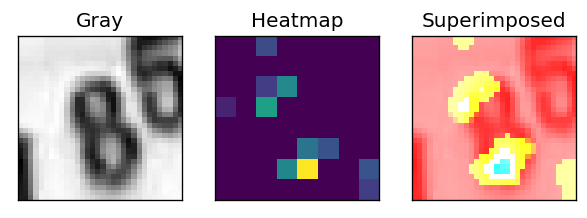

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Freezing the convolution base completely performs poorly: at most 64% val.accuracy is achieved. It looks like features extracted from VGG16 do not work well for classification of digits in this dataset. Unfreezing all 3 conv. layers from block5 improves val.accuracy to 83.5%, simultaneously causing very strong overfit. Adding one Dropout layer before output layer only slightly decreases overfit. Note, formatting of val.accuracy and accuracy on the graph is switched (unknown to me bug). (length: 491)



Max val score: 98.85%


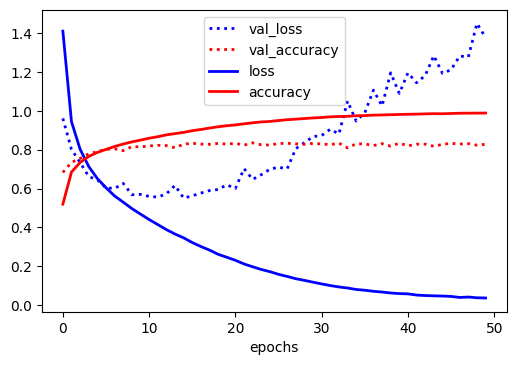

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________
None


def build_model_4_1():
  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))
  for layer in conv_base.layers:
    if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3':
      layer.trainable = True
    else:
      layer.trainable = False

  optimizer=tf.keras.optimizers.RMSprop(lr=2e-5)
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model



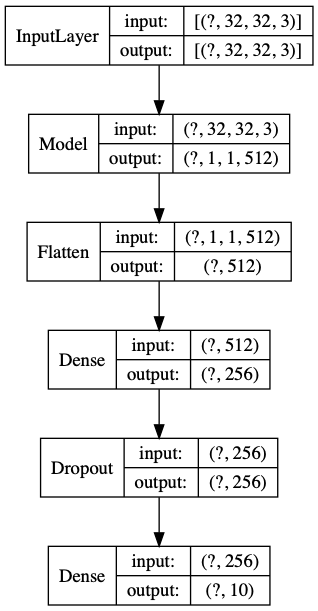

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

In a pipeline I tried different combinations of preprocessors (Normalizer,PowerTransformer,RobustScaler,StandardScaler) and classifiers (SVC,KNeighborsClassifier,LogisticRegression). Accuracy that all of them on the test data was very similar, just over 83% in all cases. This result is similar to model_4_1(the source of the conv.base). So far the best result was achieved by convnet model_2_1 without data augmentation, with 95.4% val.accuracy. I was not able to beat this result after. (length: 489)

Pipeline(steps=[('preprocessor', Normalizer()), ('clf', SVC(random_state=1))])
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  # Load the model:
  model = load_model_from_file(base_dir, 'model_4_1')
  # Retrieve the convolution base from the model:
  conv_base_model = model.layers[0]

  # Run train and test images through conv base:
  embeddings_train = conv_base_model.predict(X_train)
  embeddings_test = conv_base_model.predict(X_test)

  #Store the embeddings:

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 25.21 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
